# Assignment
The file ts.csv contains measurements extracted from satellite images for several agricultural fields during the year 2017. Each column corresponds to a field, and each row to a date where the satellite passed over the fields. These measurements provide very useful information on the time evolution of the crop. In particular, they all present a sudden change in behavior which correspond to the harvest of the field.

* Show that the time-series are non-stationary.
* Propose and implement a methodology to determine the date at which the field was harvested. Clearly state your modeling hypotheses.
* Can you additionally provide a confidence level on your prediction?

## Execution

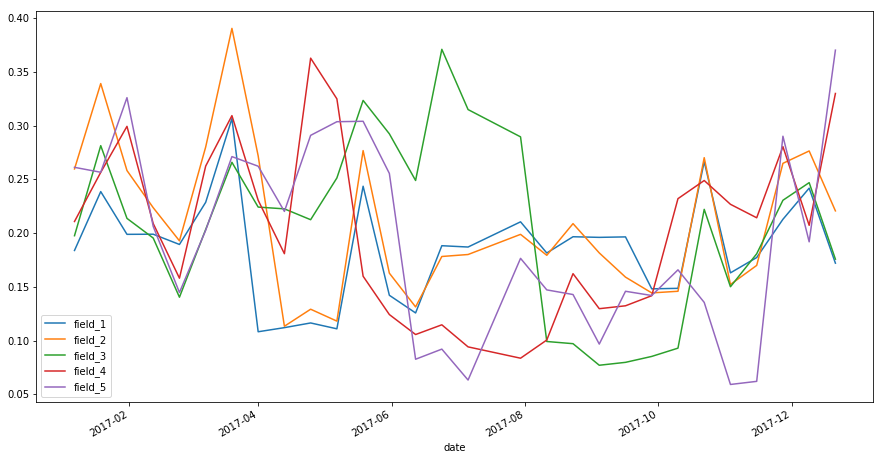

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = [15, 8]


def load_data(path: str) -> pd.DataFrame:
    # Load dataframe
    df = pd.read_csv(path)
    # Properly set date dtype
    df["date"] = pd.to_datetime(df.date, infer_datetime_format=True)
    # set date as index
    df = df.set_index("date")
    return df


df = load_data("data/ts.csv")

_ = df.plot()

In [9]:
# Are data equally sampled?
def is_equally_sampled(df):
    dates = df.reset_index()[["date"]]
    periods = dates.date.diff().value_counts()
    print(periods)
    return len(periods) == 1


is_equally_sampled(df)

12 days    27
24 days     1
Name: date, dtype: int64


False

Measures are normally taken every 12 days, but there is a missing data between 2017-07-06 and 2017-07-30. We will try to reconstruct it by linear interpolation.

In [10]:
upsampled = df.resample("12d")
df = upsampled.interpolate(method="linear")

is_equally_sampled(df)

12 days    29
Name: date, dtype: int64


True

We can observe a lot of noise in this data. 

As first step, we apply a low pass filter to the data in order to have more nuance shapes. The time window we chose is 36 days, so in every slot is composed by at least 3 measures.

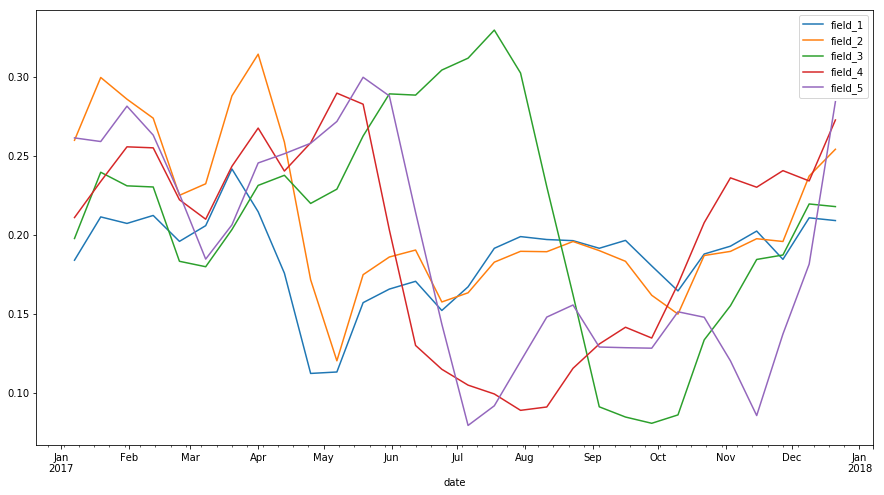

In [11]:
df_orig = df.copy(deep=True)
df = df.rolling("36d").mean().dropna()
_ = df.plot()

## (a)

From a first visual inspection, there is an obvious seasonality in these timeseries: is the effect of crop harvesting, which seems to happen between May and August.

We proceed testing the hypothesis that the data is non-stationary. A stationary time series is one whose properties do not depend on the time at which the series is observed. 

We consider the months until May 2017 (that we suppose to be before harvesting), between May and August (harvesting season) and from September 2017 (after harvesting). Let's compare the average values in different part of the year. 

In [12]:
harv_start = pd.to_datetime("2017.5.1")
harv_end = pd.to_datetime("2017.9.1")
stats = pd.DataFrame()
stats["mean_pre"] = df.loc[:harv_start].mean()
stats["std_pre"] = df.loc[:harv_start].std()
stats["mean_harv"] = df.loc[:harv_start].mean()
stats["std_harv"] = df.loc[:harv_start].std()
stats["mean_post"] = df.loc[harv_end:].mean()
stats["std_post"] = df.loc[harv_end:].std()
stats

,mean_pre,std_pre,mean_harv,std_harv,mean_post,std_post
field_1,0.195959,0.034491,0.195959,0.034491,0.191900,0.013883
field_2,0.260734,0.042087,0.260734,0.042087,0.194484,0.031052
field_3,0.215249,0.022540,0.215249,0.022540,0.143954,0.056301
field_4,0.239561,0.020210,0.239561,0.020210,0.199604,0.051386
field_5,0.243491,0.029452,0.243491,0.029452,0.149293,0.053272


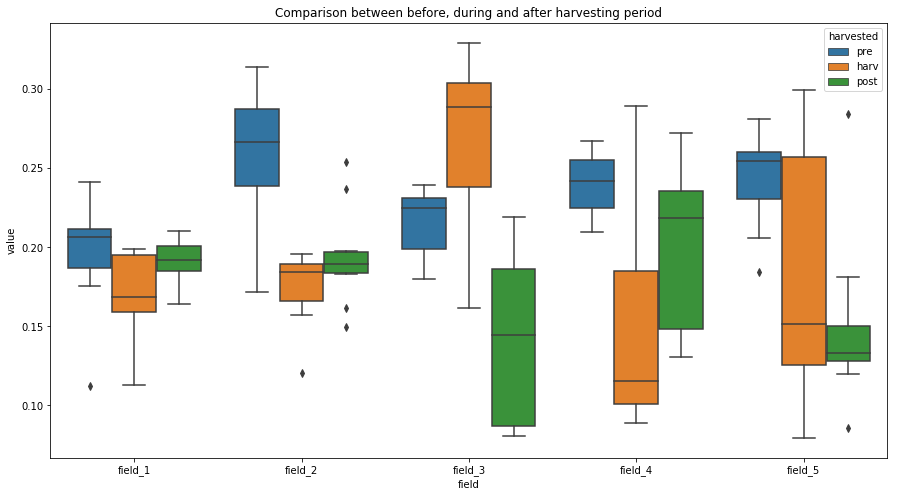

In [13]:
def time_of_year(date):
    time = "harv"
    if date < harv_start:
        time = "pre"
    elif date > harv_end:
        time = "post"
    return time


tidy = df.reset_index().melt(
    id_vars="date",
    value_vars=["field_1", "field_2", "field_3", "field_4", "field_5"],
    var_name="field",
)

tidy["harvested"] = tidy.date.apply(time_of_year)

ax = sns.boxplot(x="field", y="value", hue="harvested", data=tidy)
_ = ax.set_title(
    f"Comparison between before, during and after harvesting period"
)

We can observe clearly suspect non-stationarity on fields 2 to 5, because mean and variance are different in each time period. In the first field this effect is less evident.

The results is also a indicate the presence of seasonality in the data. This is already an indicator of non-stationarity, but to verify itwe will proceed by using a statistical test, the Augmented Dickey-Fuller test.

This test is designed to test the null hypothesis that the data are non stationary.

In [14]:
from statsmodels.tsa.stattools import adfuller

for field in df.columns:
    adf, pvalue, _, nobs, criticalvalues, _ = adfuller(df[field])
    print(
        f"""
        Results for {field}:
        ADF Statistic: {adf}, p-value: {pvalue}
        Critical Values:"""
    )
    for key, value in criticalvalues.items():
        print(f"\t{key}: {value}")


        Results for field_1:
        ADF Statistic: -2.176369667574261, p-value: 0.21493340311114895
        Critical Values:
	1%: -3.6790595944893187
	5%: -2.9678817237279103
	10%: -2.6231583472057074

        Results for field_2:
        ADF Statistic: -3.209808268704802, p-value: 0.019423911784973037
        Critical Values:
	1%: -3.6889256286443146
	5%: -2.9719894897959187
	10%: -2.6252957653061224

        Results for field_3:
        ADF Statistic: -2.452405924418258, p-value: 0.1274879393273875
        Critical Values:
	1%: -3.6889256286443146
	5%: -2.9719894897959187
	10%: -2.6252957653061224

        Results for field_4:
        ADF Statistic: -2.124566777437428, p-value: 0.23475159239417837
        Critical Values:
	1%: -3.7238633119999998
	5%: -2.98648896
	10%: -2.6328004

        Results for field_5:
        ADF Statistic: -1.5178534838703632, p-value: 0.5246617165279817
        Critical Values:
	1%: -3.7238633119999998
	5%: -2.98648896
	10%: -2.6328004


Based on the results of the test we cannot reject the null hypothesis, which means that data present a non-stationary behaviour.

We should consider that the result of the test may also have been influenced by the smoothing and the limited amount of data for each time series.

## (b)

Based on the observed and available data, I propose a simple algorithm for the estimation of the time interval of the harvesting. 

The assumption of the algorithm are:

1. That harvesting happens once a year
2. That the measured function tends to be smaller after the harvesting than on other periods of the year 
4. That right after harvesting we have the largest variation of the measured  function
3. That the algorithm would not run on one-year data (no real time or partial data)

Based on these assumption, I identify the harvesting time-period with the following steps:

1. Function differentiation (approximation of the first derivative)
2. Search for the global minimum in the differenced functino (largest difference between two consecutive points in the original):
    This would indicate that the harvesting had happened. 
3. Select an interval of 3 time-points ending at the minimum. The period of three months is based on the fact that the function has been smoothed with a 3 points rolling window, hence introducing a delay.
4. Search for a local maximum (of the original function) within the interval, and update the interval to start at this point. The idea here is that a while the function is increasing, we can be confident that the harvesting has not happened yet.

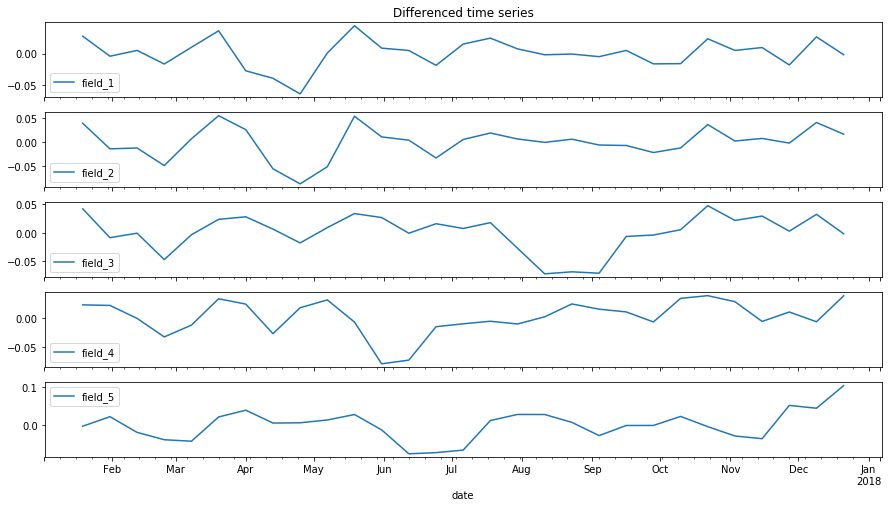

In [15]:
_, axs = plt.subplots(5, 1, sharex=True)
axs[0].set_title("Differenced time series")
for f, ax in zip(df.columns, axs):
    df[f].diff().plot(ax=ax, legend=True)

Harvest date estimation:

-> for field_1 is between 2017-03-20 and 2017-04-25

-> for field_2 is between 2017-04-01 and 2017-04-25

-> for field_3 is between 2017-07-18 and 2017-08-11

-> for field_4 is between 2017-05-07 and 2017-05-31

-> for field_5 is between 2017-05-19 and 2017-06-12



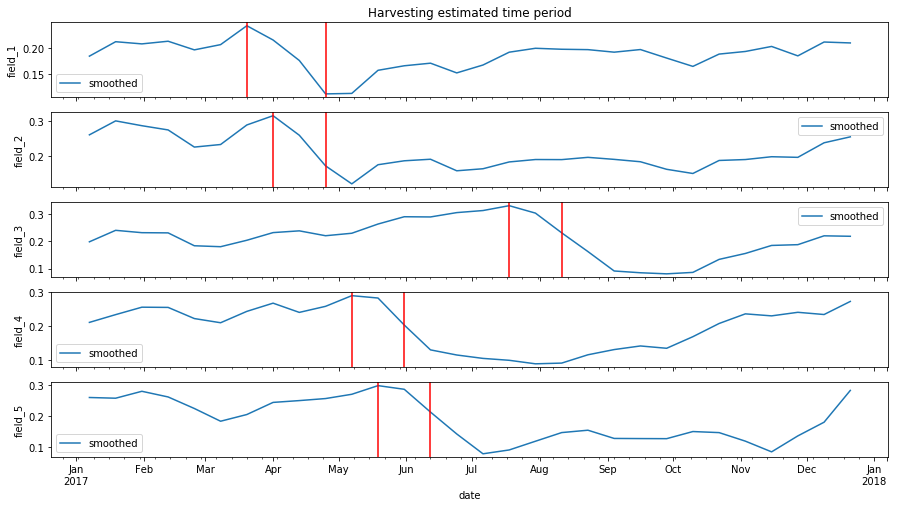

In [16]:
def find_harvest_interval(df: pd.DataFrame, f: int) -> tuple:

    # find global minimum
    global_min = df[f].diff().idxmin()
    position = df.index.get_loc(global_min)

    # set the interval between global minimum and 3 points before
    # (because data are smoothed with a 3 points time window)
    beg = df.index[position - 3]
    end = df.index[position]

    # update the beginning to the maximum whithin the selected interval
    beg = df[beg:end][f].idxmax()

    return beg, end


print("Harvest date estimation:\n")

_, axs = plt.subplots(5, 1, sharex=True)
axs[0].set_title("Harvesting estimated time period")

for f, ax in zip(df.columns, axs):
    df[f].plot(ax=ax, label="smoothed", legend=True)
    ax.set_ylabel(f)

    beg, end = find_harvest_interval(df, f)

    ax.axvline(beg, color="r")
    ax.axvline(end, color="r")

    print(f"-> for {f} is between {beg.date()} and {end.date()}\n")

## (c)

The simple algorithm proposed in (b) has some  inconveniences. For example, it doesn't offer natively a value of confidence for the estimation.

To address this point, we can compare with a statistical test the means of the periods before and after harvesting, looking for a statistical difference in the data. We will use a z-testfor this purpose.

In [17]:
# Collect and align pre and post intervals

pre = []
post = []

delta = pd.Timedelta("90d")

for f in df.columns:
    beg, end = find_harvest_interval(df, f)
    pre.append(df[beg - delta : beg].reset_index(drop=True)[f])
    post.append(df[end : end + delta].reset_index(drop=True)[f])

pre = pd.concat(pre, axis=1).dropna()
post = pd.concat(post, axis=1).dropna()

In [18]:
from statsmodels.stats.weightstats import ztest


differences, pvalues = ztest(pre, post)

for field, (d, P) in enumerate(zip(differences, pvalues)):
    print(f"In field_{field}, Pre and Post  differs with a confidence of {P} ")

In field_0, Pre and Post  differs with a confidence of 8.461358539479018e-06 
In field_1, Pre and Post  differs with a confidence of 1.0037250456512591e-13 
In field_2, Pre and Post  differs with a confidence of 1.3900218546732643e-09 
In field_3, Pre and Post  differs with a confidence of 3.322952023963281e-15 
In field_4, Pre and Post  differs with a confidence of 2.0827919183335192e-07 
